In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import json
from typing import Union

import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
import scienceplots
plt.style.use(['science', 'std-colors'])
#Options
plt.rcParams['font.size'] = 9
from simulation import SimulationData

In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_evals_distribution(ax: Axes, simulation: SimulationData, num_eigenvalues: int, kde_bw:float,  plot_settings = dict()):
    true_eigvals = np.exp(-np.arange(num_eigenvalues))
    
    for val in true_eigvals[:3]:
        ax.axvline(np.log(val), c='k', lw=1.0, alpha=0.5)
    for val in true_eigvals[3:]:
        ax.axvline(np.log(val), c='k', lw=0.5, alpha=0.3)

    def kde(estimator:str, bandwidth = None):
        evals = simulation.eigenvalues[estimator].real
        evals = evals[np.greater(evals, 0)] #Dropping negative values
        evals = np.log(evals)
        evals = evals.ravel() #Flattening
        return scipy.stats.gaussian_kde(evals, bw_method= bandwidth)

    PCR_kde = kde('PCR', bandwidth = kde_bw)
    RRR_kde = kde('RRR', bandwidth = kde_bw)

    x = np.linspace(-num_eigenvalues, 1, 300)

    ax.fill_between(x, PCR_kde(x), color= colors[0], alpha = 0.2)
    ax.plot(x, PCR_kde(x), color= colors[0])

    ax.fill_between(x, RRR_kde(x), color= colors[2], alpha = 0.2)
    ax.plot(x, RRR_kde(x), color= colors[2])
    ax.margins(0)

    plot_configs = {
        "yticks": [],
        "xticks": np.arange(-(num_eigenvalues - 1), 1),
        "xticklabels": ["$e^{" + str(i) + "}$" for i in np.arange(-(num_eigenvalues - 1), 1)],
        "xlim": (-num_eigenvalues, 1)
    }
    plot_configs = plot_configs | plot_settings
    ax.set(**plot_configs)

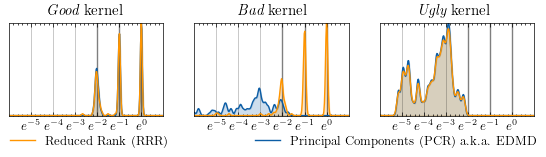

In [4]:
plot_instructions = [
    { #Good
        'path': 'data/HermitePoly_good_1140_19_1_23.pkl',
        'num_evals': 6,
        'plot_settings': {
            'title': r"{{\it Good}} kernel"
        },
        'kde_bw': 0.05
    },
    { #Bad
        'path': 'data/HermitePoly_bad_1140_19_1_23.pkl',
        'num_evals': 6,
        'plot_settings': {
            'title': r"{{\it Bad}} kernel"
        },
        'kde_bw': 0.05
    },
    { #Ugly
        'path': 'data/HermitePoly_ugly_1611_19_1_23.pkl',
        'num_evals': 6,
        'plot_settings': {
            'title': r"{{\it Ugly}} kernel"
        },
        'kde_bw': 0.005
    }
]

pt_to_inch = 0.0138889
width_pts = 487.8225
width_inches = width_pts*pt_to_inch
fig, axes = plt.subplots(ncols=3, figsize = (width_inches, 1.2))

for idx, instructions in enumerate(plot_instructions):
    with open(instructions['path'], 'rb') as f:
        simulation = pickle.load(f)
    ax = axes[idx]
    plot_evals_distribution(
        ax, 
        simulation, 
        instructions['num_evals'],
        instructions['kde_bw'], 
        plot_settings=instructions['plot_settings']
    )
legend_elements = [
    Line2D([0], [0], color=colors[2], label='Reduced Rank (RRR)'),
    Line2D([0], [0], color=colors[0], label='Principal Components (PCR) a.k.a. EDMD')
]
fig.legend(handles = legend_elements, mode = 'expand', ncols = 2, bbox_to_anchor=(0.11, -0.2, 0.81, 0.2), loc='center')
fig.savefig('figs/evals_distribution.pdf')

#### MISC reports

In [ ]:
fig, ax = plt.subplots()

true_eigvals = np.flip(np.exp(-np.arange(simulation.configs_dump['rank']*2)))
PCR_s = np.sort(simulation.eigenvalues['PCR'].real, axis=1)
RRR_s = np.sort(simulation.eigenvalues['RRR'].real, axis=1)


for i in range(PCR_s.shape[1]):
    ax.plot(RRR_s[:, i],'+', c=colors[2], ms = 5, label='RRR')
    ax.plot(PCR_s[:, i],'.', c=colors[0], ms = 2, label='PCR')

for val in true_eigvals:
    ax.axhline(val, c='k', lw=0.5, alpha=0.7)

ax.margins(x=0)
ax.set_ylabel(r"Estimated eigenvalues $\hat{\lambda}_{i}$")
ax.set_xlabel("Independent Simulation \\#")
ax.set_yscale('log')

legend_elements = [
    Line2D([0], [0], color='k', lw=0.5, alpha=0.7, label='True eigenvalues'),
    Line2D([0], [0], marker = '+', color=colors[2], ms = 5, lw=0, label='Reduced rank regression'),
    Line2D([0], [0], marker = '.', color=colors[0], ms = 2, lw=0, label='Principal component regression')
    ]
ax.legend(handles=legend_elements, frameon=True, framealpha=1, loc='lower center')
ax.set_ylim(2e-4, 1.5)
ax.set_title("Estimation of the largest eigenvalues")
fig.savefig("figs/evals_bias.pdf")